Scintillation Patterns
----------------------

In [26]:
import numpy
import matplotlib.pylab as plt
import matplotlib.colors as colors
from tqdm import tqdm, trange, tqdm_notebook
from astropy.io import fits

import aotools
from aotools.turbulence import ft_phase_screen
j = 0+1j

In [80]:
def W(f, z, cn2, wvl=500e-9):
    '''
    Spatial power spectrum of irradiance fluctuations (Tokovinin 2002)

    Assumes Kolmogorov turbulence and weak perturbation limit.
    '''
    return 3.9e-2 * (2*numpy.pi/wvl)**2 * cn2 * f**(-11/3) * (numpy.sin(numpy.pi * wvl * z * f**2))**2

In [67]:
# Set up parameters for creating phase screens
N_scrns = 500 # Number of phase screens to average over to get spatial power spectrum
nx_size = 512
D = 4.
pxl_scale = D/nx_size
r0 = 0.32 # Need large r0 (weak turbulence) to ensure no saturation of scintillation
L0 = 100
l0=0.001
wind_speed = 10 #m/s - just arbitrarily set
z = 10000. # propagation distance

In [68]:
# Generate phase screens
phase_screens = numpy.array([ft_phase_screen(r0, nx_size, pxl_scale, L0, l0) for i in range(N_scrns)])

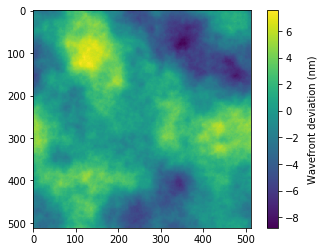

In [69]:
plt.figure()
plt.imshow(phase_screens[0])
cbar = plt.colorbar()
cbar.set_label('Wavefront deviation (nm)', labelpad=8)

In [70]:
propagated_screens = numpy.array([aotools.opticalpropagation.angularSpectrum(numpy.exp(j*i), 500e-9, pxl_scale, pxl_scale, 10000.) for i in phase_screens])

In [71]:
I = numpy.abs(propagated_screens)**2 # Scintillation intensity patterns

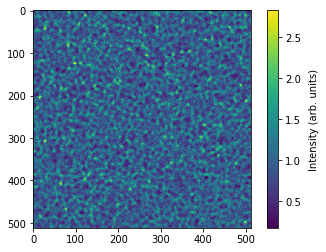

In [72]:
plt.figure()
plt.imshow(I[0])
cbar = plt.colorbar()
cbar.set_label('Intensity (arb. units)', labelpad=8)

In [73]:
powerspecs_2d = numpy.array([abs(aotools.fouriertransform.ft2(i, D/nx_size))**2 for i in I])

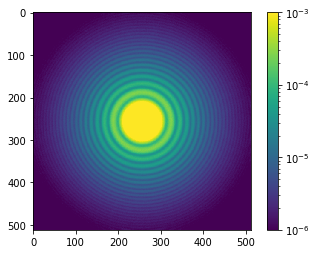

In [75]:
# Plot 2d irradiance power spectrum
plt.figure()
plt.imshow(powerspecs_2d.mean(0), norm=colors.LogNorm(1e-6,1e-3))
cbar = plt.colorbar()

In [76]:
# Take azimuthal avg of 2d spatial power spectrum to compare with theory
powerspec_1d = aotools.azimuthal_average(powerspecs_2d.mean(0))

In [77]:
fs = numpy.fft.fftshift(numpy.fft.fftfreq(nx_size, d=D/nx_size))[int(nx_size/2)+1:] # Fourier space coordinates

In [82]:
# Theoretical power spectrum
W_th = W(fs, z, aotools.r0_to_cn2(r0))

(0, 25)

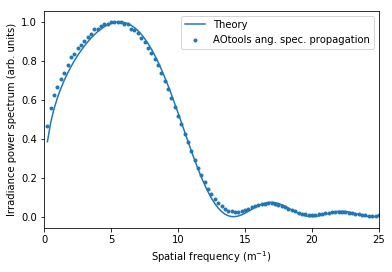

In [81]:
plt.figure()
plt.plot(fs, W_th/W_th.max(), label='Theory')
plt.scatter(fs, powerspec_1d[1:]/powerspec_1d[1:].max(), marker='.', label='AOtools ang. spec. propagation')
plt.xlabel('Spatial frequency (m$^{-1}$)')
plt.ylabel('Irradiance power spectrum (arb. units)')
plt.legend(loc=0)
plt.xlim(0,25)